_Version log: Using scikit-learn insted of scipy.optimize to make it faster and more accurate._

In [2]:
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as spimg
from scipy import optimize as spopt, fft as spfft
from PIL import Image #I prefer Pillow to imageio


To turn a sparce signal $X$ into the full image $Y$. The L1 norm of,
\begin{equation}
    \mathcal{F} (Y),
\end{equation}
needs to be minimised while also minimising the L2 norm of,
\begin{equation}
    C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X,
\end{equation}
where $\mathcal{F}( )$ is the DCT, $I$ is an identerty matrix and $C$ is a cropping transformation matrix such that,
\begin{equation}
    C \times Y = X.
\end{equation}
The weighting between the first two equation can be changed using the regularisation coeffient, $\alpha$. Altogether the function that needs to be minimised looks like,
\begin{equation}
    ||C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X||_{2} + \alpha ||\mathcal{F} (Y)||_{1},
\end{equation}
which can be re-writtern in terms of the measurement matrix $A$ and $\mathcal{F} (Y) = Z$ as,
\begin{equation}
    ||A \times Z - X||_{2} + \alpha ||Z||_{1}.
\end{equation}

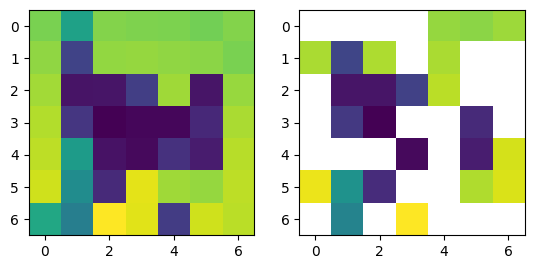

In [5]:
compression = 0.01 #fraction of the image to keep (The image is too large to process quickly)

# original image
img = Image.open('data\\alfie.png') # read image
img = np.array(img).sum(axis=2) # make image grayscale
target = spimg.zoom(img, compression) # scipy ndimage.zoom compresses (or interpolates) an image.
total_points = np.multiply(*target.shape)
target_flat = target.flatten()

# image subsample
subsample = 0.5 #fraction of the image to subsample
random_points = np.random.choice(total_points, round(total_points *subsample), replace= False)
random_points = np.sort(random_points) #Not nessisary but makes it easier to look at.
signal_flat = np.full(total_points, np.nan)
signal_flat[random_points] = target_flat[random_points]
signal_sparce = target_flat[random_points]
signal = np.reshape(signal_flat, target.shape)

fig, axs = plt.subplots(1,2)

axs[0].imshow(target, interpolation= "nearest")
axs[1].imshow(signal, interpolation= "nearest")

plt.show()

In [6]:
target.shape

(7, 7)

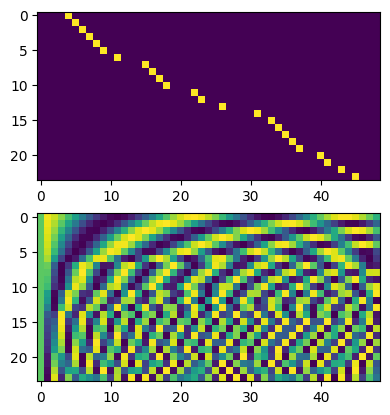

In [7]:
cropping_matrix = np.identity(total_points, dtype= np.float16)
cropping_matrix = cropping_matrix[random_points] #cropping matrix operator

dct_matrix = spfft.idct(np.identity(total_points, dtype= np.float16), axis= 0)
measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

fig, axs = plt.subplots(2,1)

axs[0].imshow(cropping_matrix, interpolation= "nearest")
axs[1].imshow(measurement_matrix, interpolation= "nearest")

plt.show()

In [16]:
regularization_coeffient = 1e-7 #don't go below 1e-8. (floating point error?)

lasso = Lasso(alpha=regularization_coeffient)
lasso.fit(measurement_matrix, signal_sparce)
result_FFT = lasso.coef_

print(result_FFT.shape)
print(total_points)

(21609,)
21609


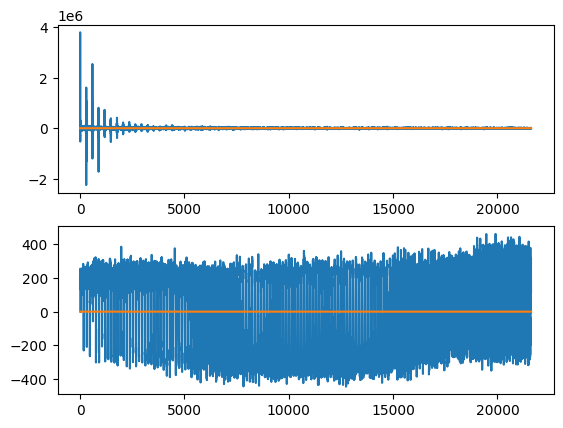

In [17]:
result_flat = spfft.idct(result_FFT)

fig, axs = plt.subplots(2,1)

axs[0].plot(np.real(result_FFT))
axs[0].plot(np.imag(result_FFT)) #I was using the FFT insted of the DCT.
axs[1].plot(np.real(result_flat))
axs[1].plot(np.imag(result_flat))

plt.show()

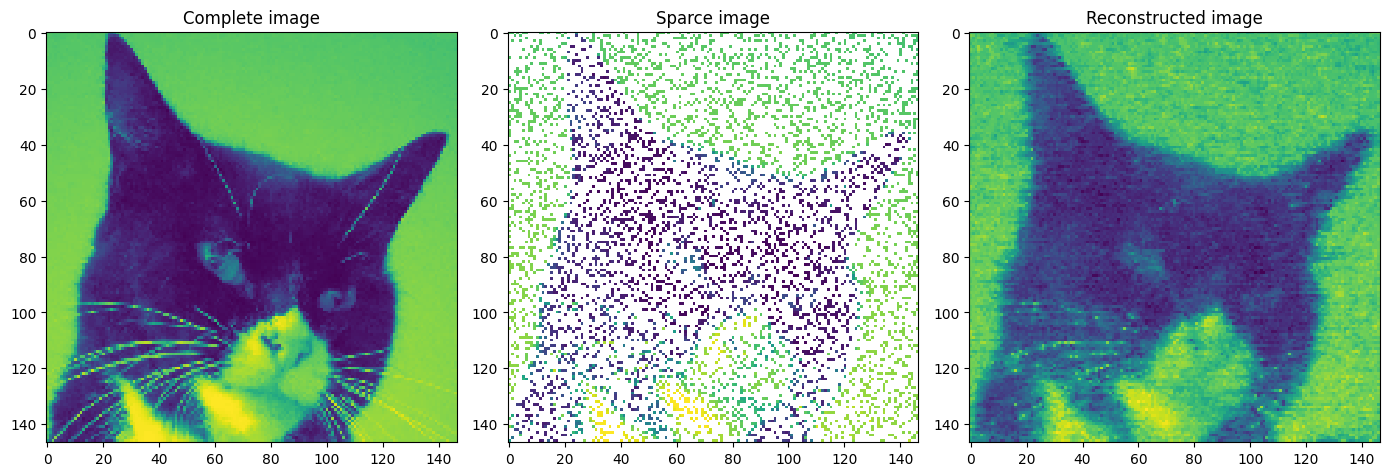

In [19]:
result = np.reshape(result_flat, target.shape)

fig, axs = plt.subplots(1,3, figsize= (14,8))
axs[0].imshow(target, interpolation = "nearest")
axs[0].set_title("Complete image")
axs[1].imshow(signal, interpolation = "nearest")
axs[1].set_title("Sparce image")
axs[2].imshow(result, interpolation = "nearest")
axs[2].set_title("Reconstructed image")

plt.tight_layout()
plt.show()